# 2024-04-18-Analysis: Verify CPA performance using legacy Theis lab fork

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import cpa
import anndata as ad

%load_ext autoreload
%autoreload 2

Global seed set to 0


## Load training dataset

In [ ]:
data_path = "./notebooks/neurips2025/perturbench_data/"

In [ ]:
adata = sc.read_h5ad(f'{data_path}/norman19_cpa_hvg_normalized_curated.h5ad')
adata

AnnData object with n_obs × n_vars = 111122 × 5044
    obs: 'guide_id', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'perturbation', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'n_counts', 'condition', 'pert_type', 'cell_type', 'source', 'condition_ID', 'control', 'dose_value', 'pathway', 'cov_cond', 'pert', 'split_hardest', 'split_1', 'split_2', 'split_3', 'split_4', 'split_5', 'split_6', 'cond_harm', 'split'
    var: 'ensemble_id', 'ncounts', 'ncells', 'symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'gene_embedding_path', 'hvg', 'log1p', 'neighbors', 'rank_genes_groups_cov', 'source_colors', 'split_1_colors', 'split_2_colors', 'split_3_colors', 'split_4_colors', 'split_5_colors', 'split_hardest_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivi

In [3]:
adata.X = adata.layers['counts']

In [ ]:
split = pd.read_csv(
    f'{data_path}/norman19_cpa_hvg_normalized_splits/split_6.csv',
    index_col=0,
    header=None,
).iloc[:, 0]
split.head()

0
CCCATACCATTCTTAC     test
CTCATTAGTAAGAGAG      val
CACACCTCATGAACCT    train
AGATCTGTCACCAGGC    train
ATGTGTGCAAGCCGCT    train
Name: 1, dtype: object

In [5]:
adata.obs['split'] = split.loc[adata.obs_names]
adata.obs['split'] = adata.obs['split'].map({
    'train': 'train',
    'val': 'valid',
    'test': 'ood'
})
adata.obs['split'].value_counts()

split
train    83375
valid    21038
ood       6709
Name: count, dtype: int64

## Train CPA

In [6]:
cpa.CPA.setup_anndata(
    adata, 
    perturbation_key='cond_harm',
    control_group='ctrl',
    dosage_key='dose_value',
    categorical_covariate_keys=['cell_type'],
    is_count_data=True,
    deg_uns_key='rank_genes_groups_cov',
    deg_uns_cat_key='cov_cond',
    max_comb_len=2,
)

100%|██████████| 235/235 [00:00<00:00, 943.96it/s] 
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [7]:
model_params = {
    "n_latent": 32,
    "recon_loss": "nb",
    "doser_type": "linear",
    "n_hidden_encoder": 256,
    "n_layers_encoder": 4,
    "n_hidden_decoder": 256,
    "n_layers_decoder": 2,
    "use_batch_norm_encoder": True,
    "use_layer_norm_encoder": False,
    "use_batch_norm_decoder": False,
    "use_layer_norm_decoder": False,
    "dropout_rate_encoder": 0.2,
    "dropout_rate_decoder": 0.0,
    "variational": False,
    "seed": 8206,
}

trainer_params = {
    "n_epochs_kl_warmup": None,
    "n_epochs_adv_warmup": 50,
    "n_epochs_mixup_warmup": 10,
    "n_epochs_pretrain_ae": 10,
    "mixup_alpha": 0.1,
    "lr": 0.0001,
    "wd": 3.2170178270865573e-06,
    "adv_steps": 3,
    "reg_adv": 10.0,
    "pen_adv": 20.0,
    "adv_lr": 0.0001,
    "adv_wd": 7.051355554517135e-06,
    "n_layers_adv": 2,
    "n_hidden_adv": 128,
    "use_batch_norm_adv": True,
    "use_layer_norm_adv": False,
    "dropout_rate_adv": 0.3,
    "step_size_lr": 25,
    "do_clip_grad": False,
    "adv_loss": "cce",
    "gradient_clip_value": 5.0,
}

In [8]:
model = cpa.CPA(
    adata=adata, 
    split_key='split',
    train_split='train',
    valid_split='valid',
    test_split='ood',
    **model_params,
)

Global seed set to 8206


In [9]:
model.train(
    max_epochs=2000,
    use_gpu=True, 
    batch_size=2048,
    plan_kwargs=trainer_params,
    early_stopping_patience=5,
    check_val_every_n_epoch=5,
    save_path='./lightning_logs/Norman2019/',
)

100%|██████████| 235/235 [00:01<00:00, 129.28it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5/2000:   0%|          | 4/2000 [02:06<17:38:51, 31.83s/it, v_num=1, recon=1.35e+3, r2_mean=0.897, adv_loss=5.58, acc_pert=0.00308]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/2000:   0%|          | 9/2000 [04:58<18:18:21, 33.10s/it, v_num=1, recon=1.31e+3, r2_mean=0.932, adv_loss=5.56, acc_pert=0.00377, val_recon=1.39e+3, disnt_basal=0.00976, disnt_after=0.21, val_r2_mean=0.878, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.011737451433515634
disnt_after = 0.2206423594761941
val_r2_mean = 0.9170139037845225
val_r2_var = 0.2092964436317364
Epoch 20/2000:   1%|          | 19/2000 [10:34<17:41:02, 32.14s/it, v_num=1, recon=1.29e+3, r2_mean=0.949, adv_loss=5.52, acc_pert=0.00524, val_recon=1.3e+3, disnt_basal=0.0129, disnt_after=0.178, val_r2_mean=0.942, val_KL=nan] 
disnt_basal = 0.012359933477133205
disnt_after = 0.1682316221878209
val_r2_mean = 0.9465146980824457
val_r2_var = 0.27751451181808034
Epoch 25/2000:   1%|          | 24/2000 [13:24<17:57:21, 32.71s/it, v_num=1, recon=1.29e+3, r2_mean=0.952, adv_loss=5.49, acc_pert=0.00605, val_recon=1.29e+3, disnt_basal=0.0124, disnt_after=0.168, val_r2_mean=0.947, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/2000:   1%|▏         | 29/2000 [16:09<17:33:09, 32.06s/it, v_num=1, recon=1.28e+3, r2_mean=0.954, adv_loss=5.47, acc_pert=0.00654, val_recon=1.29e+3, disnt_basal=0.0125, disnt_after=0.169, val_r2_mean=0.951, val_KL=nan]


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.012138732537580658
disnt_after = 0.16875821686647025
val_r2_mean = 0.9528368481355198
val_r2_var = 0.30146596810190884
Epoch 35/2000:   2%|▏         | 34/2000 [18:54<17:38:57, 32.32s/it, v_num=1, recon=1.28e+3, r2_mean=0.957, adv_loss=5.45, acc_pert=0.0073, val_recon=1.28e+3, disnt_basal=0.0121, disnt_after=0.169, val_r2_mean=0.953, val_KL=nan] 


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/2000:   2%|▏         | 39/2000 [21:45<18:00:17, 33.05s/it, v_num=1, recon=1.28e+3, r2_mean=0.958, adv_loss=5.43, acc_pert=0.00812, val_recon=1.28e+3, disnt_basal=0.0121, disnt_after=0.166, val_r2_mean=0.955, val_KL=nan]


Epoch 00039: cpa_metric reached. Module best state updated.



disnt_basal = 0.012220153672951034
disnt_after = 0.1667200272992125
val_r2_mean = 0.954337911160069
val_r2_var = 0.3204418112107931
Epoch 45/2000:   2%|▏         | 44/2000 [24:35<17:54:58, 32.97s/it, v_num=1, recon=1.28e+3, r2_mean=0.959, adv_loss=5.41, acc_pert=0.00924, val_recon=1.28e+3, disnt_basal=0.0122, disnt_after=0.167, val_r2_mean=0.954, val_KL=nan]


Epoch 00044: cpa_metric reached. Module best state updated.


Epoch 50/2000:   2%|▏         | 49/2000 [27:24<18:00:05, 33.22s/it, v_num=1, recon=1.28e+3, r2_mean=0.96, adv_loss=5.39, acc_pert=0.01, val_recon=1.28e+3, disnt_basal=0.0122, disnt_after=0.168, val_r2_mean=0.954, val_KL=nan]    


Epoch 00049: cpa_metric reached. Module best state updated.



disnt_basal = 0.012219105687255455
disnt_after = 0.1661751901545772
val_r2_mean = 0.9554466911748805
val_r2_var = 0.3337820200228708
Epoch 55/2000:   3%|▎         | 54/2000 [30:12<17:49:19, 32.97s/it, v_num=1, recon=1.27e+3, r2_mean=0.961, adv_loss=5.37, acc_pert=0.0112, val_recon=1.28e+3, disnt_basal=0.0122, disnt_after=0.166, val_r2_mean=0.955, val_KL=nan]


Epoch 00054: cpa_metric reached. Module best state updated.


Epoch 60/2000:   3%|▎         | 59/2000 [32:59<17:28:43, 32.42s/it, v_num=1, recon=1.27e+3, r2_mean=0.961, adv_loss=5.36, acc_pert=0.0122, val_recon=1.27e+3, disnt_basal=0.0121, disnt_after=0.168, val_r2_mean=0.957, val_KL=nan]


Epoch 00059: cpa_metric reached. Module best state updated.



disnt_basal = 0.012071569690665251
disnt_after = 0.16988535932609505
val_r2_mean = 0.9574422786660645
val_r2_var = 0.33812519422076515
Epoch 65/2000:   3%|▎         | 64/2000 [35:45<17:17:19, 32.15s/it, v_num=1, recon=1.27e+3, r2_mean=0.962, adv_loss=5.34, acc_pert=0.0128, val_recon=1.27e+3, disnt_basal=0.0121, disnt_after=0.17, val_r2_mean=0.957, val_KL=nan] 


Epoch 00064: cpa_metric reached. Module best state updated.


Epoch 70/2000:   3%|▎         | 69/2000 [38:33<17:26:41, 32.52s/it, v_num=1, recon=1.27e+3, r2_mean=0.962, adv_loss=5.32, acc_pert=0.0134, val_recon=1.27e+3, disnt_basal=0.0121, disnt_after=0.171, val_r2_mean=0.958, val_KL=nan]


Epoch 00069: cpa_metric reached. Module best state updated.



disnt_basal = 0.011922687990087473
disnt_after = 0.16790645306476215
val_r2_mean = 0.9591679303272699
val_r2_var = 0.34677136989237867
Epoch 75/2000:   4%|▎         | 74/2000 [41:23<17:41:46, 33.08s/it, v_num=1, recon=1.27e+3, r2_mean=0.963, adv_loss=5.3, acc_pert=0.0145, val_recon=1.27e+3, disnt_basal=0.0119, disnt_after=0.168, val_r2_mean=0.959, val_KL=nan] 


Epoch 00074: cpa_metric reached. Module best state updated.


Epoch 80/2000:   4%|▍         | 79/2000 [44:15<17:36:58, 33.01s/it, v_num=1, recon=1.27e+3, r2_mean=0.963, adv_loss=5.29, acc_pert=0.015, val_recon=1.27e+3, disnt_basal=0.0119, disnt_after=0.171, val_r2_mean=0.959, val_KL=nan] 


Epoch 00079: cpa_metric reached. Module best state updated.



disnt_basal = 0.011798296847756932
disnt_after = 0.16909621793235854
val_r2_mean = 0.9604354566435584
val_r2_var = 0.35600624643160517
Epoch 90/2000:   4%|▍         | 89/2000 [49:53<17:31:47, 33.02s/it, v_num=1, recon=1.26e+3, r2_mean=0.964, adv_loss=5.25, acc_pert=0.0147, val_recon=1.26e+3, disnt_basal=0.0114, disnt_after=0.163, val_r2_mean=0.96, val_KL=nan]
disnt_basal = 0.011406388947235373
disnt_after = 0.16495090880998856
val_r2_mean = 0.9610663293194229
val_r2_var = 0.3592729465280483
Epoch 100/2000:   5%|▍         | 99/2000 [55:37<17:39:10, 33.43s/it, v_num=1, recon=1.26e+3, r2_mean=0.965, adv_loss=5.23, acc_pert=0.015, val_recon=1.26e+3, disnt_basal=0.0112, disnt_after=0.161, val_r2_mean=0.962, val_KL=nan]
disnt_basal = 0.011350173034583595
disnt_after = 0.1635565246300523
val_r2_mean = 0.9633952096263901
val_r2_var = 0.35970433574681787
Epoch 105/2000:   5%|▌         | 105/2000 [59:09<17:47:46, 33.81s/it, v_num=1, recon=1.26e+3, r2_mean=0.965, adv_loss=5.21, acc_pert=0.0172, 

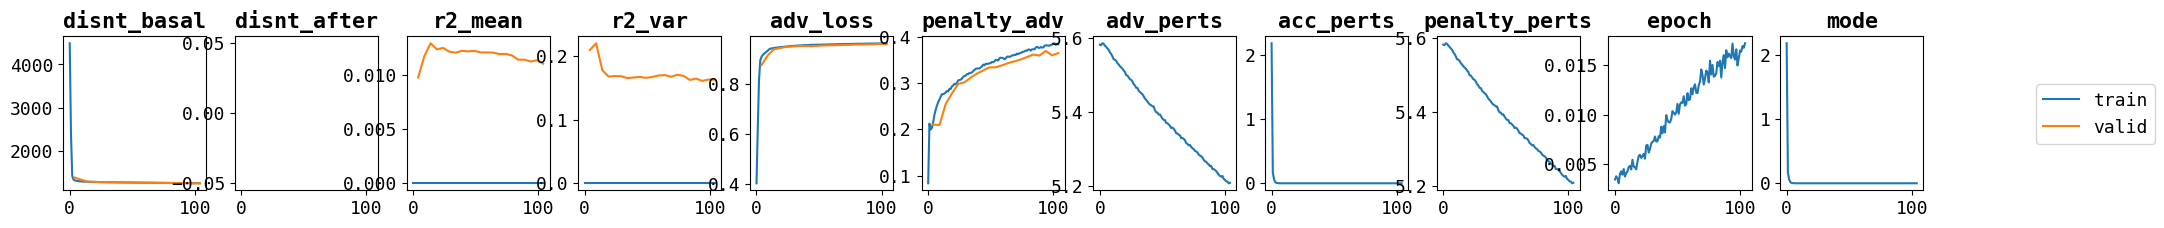

In [10]:
cpa.pl.plot_history(model)

## Generate ood/test predictions

In [11]:
adata.layers['X_true'] = adata.X.copy()
ctrl_adata = adata[adata.obs['cond_harm'] == 'ctrl'].copy()
adata.X = ctrl_adata.X[np.random.choice(ctrl_adata.n_obs, size=adata.n_obs, replace=True), :]

In [ ]:
model.predict(adata, batch_size=2048)

  7%|▋         | 4/55 [00:01<00:17,  2.94it/s]

In [ ]:
adata_pred = ad.AnnData(X=adata.obsm['CPA_pred'].copy(), obs=adata.obs.copy(), var=adata.var.copy())
adata_pred

In [ ]:
adata_pred.write_h5ad(
    f'{data_path}/theis_cpa_pred_raw.h5ad'
)